In [1]:
from IPython.display import display, HTML , Markdown
from snowflake.snowpark.session import Session
from snowflake.snowpark.functions import udf, col
from torchvision.models._utils import IntermediateLayerGetter
from sklearn.metrics.pairwise import cosine_similarity
from cachetools import cached
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import base64, json ,logging
import torch
import onnx

# Import the commonly defined utility scripts using
# dynamic path include
import sys
sys.path.append('../python/lutils')
import sflk_base as L

display(Markdown("### Initialization"))
logging.basicConfig(stream=sys.stdout, level=logging.ERROR)

# Source various helper functions
%run ./scripts/notebook_helpers.py

# Define the project home directory, this is used for locating the config.ini file
PROJECT_HOME_DIR = '../..'
config = L.get_config(PROJECT_HOME_DIR)
session = L.connect_to_snowflake(PROJECT_HOME_DIR)

if(session == None):
   raise Exception(f'Unable to connect to snowflake. Validate connection information ')

session.use_role(f'''{config['APP_DB']['role']}''')
session.use_schema(f'''{config['APP_DB']['database']}.{config['APP_DB']['schema']}''')
session.use_warehouse(f'''{config['SNOW_CONN']['warehouse']}''')

df1 = session.sql('select current_user() ,current_role() ,current_database() ,current_schema();').to_pandas()
display(df1)

### Initialization

,CURRENT_USER(),CURRENT_ROLE(),CURRENT_DATABASE(),CURRENT_SCHEMA()
0,JPRUSA,SERVICESNOW_USER_ROLE,FASHION,PUBLIC


## Stages

We are currently checking to see if we have all the necessary stages to do our offline training of our recommendation engine. 
- MODEL_STG is for holding our ML models for recommendation
- MODELS is for holding our captioning LLM models (not created yet)
- FASHION REPOSITORY is for holding our docker images

In [2]:
output = session.sql('SHOW STAGES;').collect()
pd.DataFrame(output)

,created_on,name,database_name,schema_name,url,has_credentials,has_encryption_key,owner,comment,region,type,cloud,notification_channel,storage_integration,owner_role_type
0,2023-09-11 11:29:40.914000-07:00,FASHION_REPOSITORY,FASHION,PUBLIC,,N,N,SERVICESNOW_USER_ROLE,,None,IMAGE REPOSITORY,None,None,None,ROLE
1,2023-09-26 09:12:25.666000-07:00,IMAGE_STG,FASHION,PUBLIC,,N,N,SERVICESNOW_USER_ROLE,,None,INTERNAL NO CSE,None,None,None,ROLE
2,2023-08-31 14:55:29.865000-07:00,MODELS,FASHION,PUBLIC,,N,N,SERVICESNOW_USER_ROLE,,None,INTERNAL NO CSE,None,None,None,ROLE
3,2023-07-31 09:00:30.527000-07:00,MODEL_STG,FASHION,PUBLIC,,N,N,SERVICESNOW_USER_ROLE,,None,INTERNAL,None,None,None,ROLE
4,2023-09-13 13:18:56.893000-07:00,UDF_STG,FASHION,PUBLIC,,N,N,SERVICESNOW_USER_ROLE,,None,INTERNAL,None,None,None,ROLE


## Put model in stage

We first retreive the model from the models stage, where it was saved durring training in `1_image_embedding_training.ipynb`

We then put the model into staging using the PUT statement

Finally, we check that the model is in the correct staging area "@MODEL_STG"

In [32]:
model_name = 'embedding_model.pt'
session.sql(f"GET @models/{model_name} file://.").collect()
session.sql(f"PUT  file://{model_name} @MODEL_STG OVERWRITE = TRUE AUTO_COMPRESS = FALSE;").collect()

[Row(file='embedding_model.pt', size=44795880, status='DOWNLOADED', message='')]

In [34]:
# check that model was uploaded
output = session.sql("LIST @MODEL_STG;").collect();
pd.DataFrame(output)

,name,size,md5,last_modified
0,model_stg/embedding_model.pt,44795888,912200f5bf4b273b9f7987714e6ade4e,"Tue, 26 Sep 2023 21:13:41 GMT"
1,model_stg/embedding_spec.yaml,704,a4b44b47c7cbf594b3dd76d4958d12b6,"Tue, 26 Sep 2023 19:49:52 GMT"
2,model_stg/fashion_recommender_spec.yaml,512,c310527d7d4cc8690a0c61afefd2627e,"Tue, 22 Aug 2023 20:36:02 GMT"
3,model_stg/model.onnx,44696272,e28bf7c6e8042161c370f5ee2e1a1a7b,"Tue, 26 Sep 2023 20:42:17 GMT"
4,model_stg/optuna_model.sav,326928,6e6d651e85c41881296d40f538048181,"Mon, 31 Jul 2023 16:06:48 GMT"
5,model_stg/optuna_model_debug.sav,144325024,c27a538749d4f5e8eac0965da8751f0e,"Wed, 2 Aug 2023 19:49:01 GMT"
6,model_stg/spec-finetune.yaml,544,7e50a328ddef838d734c365bfdddb70c,"Fri, 1 Sep 2023 13:34:13 GMT"
7,model_stg/spec.yaml,512,e3186c3dbf97e4f946727e89a8099286,"Thu, 31 Aug 2023 21:41:02 GMT"
8,model_stg/spec_img_desc.yaml,560,3d2770bc3d4ed0caba678370f96c5599,"Thu, 31 Aug 2023 21:48:36 GMT"
9,model_stg/udf_score_optuna_model_vec_cached/ud...,3456,14927735ea3142d68351f9cdff9030b9,"Mon, 31 Jul 2023 16:08:38 GMT"


## UDF embedding

We define a few functions:
- load_model: loads our pytorch model 
- load_transform: transforms our data appropriately through resizing, normalizing, and cropping, etc.
- UDF (udf)torch_embedding_model: Calls the 2 functions above in order to load the model, decode the data from the datatable, transform the data, and performs downstream tasks on the data

Then we read in our encoded images

Then we perform inference on our encoded images using the UDF we defined earlier, and save the table as IMAGE_ENCODED within snowflake

We then visualize the table "IMAGE_ENCODED" to make sure the encoded images as well as the image embeddings are present

In [85]:
session.add_packages("cachetools", "pillow", "torchvision", "pytorch")

@cached(cache={})
def load_model(model_path: str) -> object:
    import torch
    model = torch.load(model_path)
    return model

@cached(cache={})
def load_transform() -> object:
    from torchvision import transforms
    data_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return data_transforms

@udf(name='udf_torch_embedding_model',session=session,replace=True,is_permanent=True,
     stage_location='@UDF_STG',imports=['@MODEL_STG/embedding_model.pt'])
def udf_torch_embedding_model(data: str) -> str:
    import sys
    import json
    import base64
    from io import BytesIO
    from PIL import Image
    
    
    IMPORT_DIRECTORY_NAME = "snowflake_import_directory"
    import_dir = sys._xoptions[IMPORT_DIRECTORY_NAME]
    model_name = 'embedding_model.pt'
    model = load_model(import_dir+model_name)
    transform = load_transform()
    
    img = Image.open(BytesIO(base64.b64decode(data)))
    img = transform(img).unsqueeze(0) 
    with torch.no_grad():
        embedding = model(img)['features'].squeeze()
    
    output = json.dumps([round(float(x), 3) for x in embedding])
    return output

In [88]:
# we use the table created in preprocessing_and_uploading.ipynb
sdf = session.table('IMAGES_ENCODED')
scored_sdf = sdf.with_column('EMBEDDING', udf_torch_embedding_model('DATA'))

In [95]:
%%time
# write embeddings into snowflake (executed embedding model)
scored_sdf.write.save_as_table(table_name='IMAGES_ENCODED', mode='overwrite')

CPU times: user 13.9 ms, sys: 5.43 ms, total: 19.3 ms
Wall time: 32.3 s


In [11]:
# check that everything looks correct
sdf_ = session.table('IMAGES_ENCODED')
embeddings = sdf_.limit(10).to_pandas()
embeddings

,LABEL,NAME,DATA,EMBEDDING,TEXT
0,not,not_sure_4afd4480-98bf-42df-9104-6c7fc2f5950d.jpg,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,"[2.367, 0.639, 1.66, 0.362, 1.236, 0.125, 0.69...",\n
1,hat,hat_d8b6e902-1bb0-41a8-9ffd-25309c18f1ee.jpg,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,"[0.009, 0.94, 1.333, 0.454, 2.092, 0.017, 0.67...",the clothing is a black and pink cap with the...
2,shirt,shirt_1d2e0956-07d7-41d8-9286-ea98d1d32dbd.jpg,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,"[1.697, 1.315, 0.32, 0.844, 1.39, 2.115, 0.548...",this is a blue floral print shirt\n
3,blazer,blazer_4242353e-2e82-4784-ad11-d49c10ee9808.jpg,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,"[0.167, 3.002, 0.931, 1.819, 1.997, 0.429, 0.5...",the jacket is a grey and black checker pattern\n
4,dress,dress_1da10477-cb53-4506-b54c-1ad949002e35.jpg,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,"[0.105, 0.757, 0.107, 1.791, 0.171, 5.007, 0.5...",the dress is a green linen dress with a ruffle\n
5,t,t_shirt_28709ef4-cebf-40c5-8347-f59932bf9323.jpg,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,"[0.475, 0.566, 1.764, 2.864, 0.01, 0.891, 0.04...",this is a black t shirt with a floral design ...
6,pants,pants_f9b5db75-cc6e-4883-ba11-2ef61dd58371.jpg,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,"[3.409, 0.561, 1.855, 0.344, 0.677, 1.156, 1.6...",yes\n
7,shirt,shirt_afd8adae-5b2c-410f-a0ed-2e471d48ad83.jpg,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,"[2.11, 2.01, 0.339, 1.002, 2.065, 4.003, 0.258...",this is a blouse with a long sleeve and a col...
8,pants,pants_914abed6-9cdf-4728-afa3-9d100efda766.jpg,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,"[0.811, 0.47, 0.547, 0.76, 0.283, 0.038, 0.458...",the jeans are made of denim\n
9,not,not_sure_34860e8b-0c9e-464d-848f-a4e834157edd.jpg,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,"[0.458, 0.554, 0.695, 0.124, 1.283, 0.574, 0.0...",the shirt is a black and white striped shirt\n


## Similarity

This next part visualizes the results of running the image embeddings retrieved from the last part through cosine similarity scores in order to find recommendations of clothing based on other clothing products selected.

- First we read in our encoded images table
- Then we run cosine similarity on all combinations of the image embeddings to get a similarity matrix
- then we define 3 helper functions:
    - get_image: gets the image based on image name and returns image and label of image
    - visualize_model: given a dataframe, and number of images we want to display, this function displays all the images referenced in the dataframe by leveraging "get_image"
    - given the similarity matrix, image to reference, and other parameters, it displays the top n images based on based on the image to reference by leveraging "visualize_model"
- We then show how to look up an example item to display through the file name
- We plug in the example item into our top_n function to get all the recommmendations for dresses
- We then show how to do it again for other labels such as hoodies, pants, and blazers

In [90]:
%%time
# setup for similarity stuff ~6 seconds
data_table = "IMAGES_ENCODED"
data_col = 'DATA'
name_col = 'NAME'
label_col = 'LABEL'
embedding_col = "EMBEDDING"

sdf = session.table(data_table)
img_names = sdf.select(name_col).to_pandas()

embeddings = sdf.select(embedding_col, name_col).to_pandas()
embeddings_np = list(embeddings[embedding_col].apply(lambda x: np.array(json.loads(x))))
similarity=cosine_similarity(embeddings_np)

sim_df = pd.DataFrame(similarity, 
                      columns=embeddings.NAME, 
                      index=embeddings.NAME)

CPU times: user 3 s, sys: 818 ms, total: 3.82 s
Wall time: 5.24 s


In [91]:
# retreive image and label from snowflake DB for a given file name
def get_image(img_name):
    data = sdf.filter(col(name_col) == img_name).select(label_col, data_col).to_pandas()
    img = Image.open(BytesIO(base64.b64decode(data[data_col][0])))
    label = data[label_col][0]
    return img, label

def visualize_model(df, num_images=6):
    images_so_far = 0
    fig = plt.figure()
    
    for row in df.iterrows():
        item = row[0]
        sim_score = row[1].values[0]
        
        img, label = get_image(item)
        img = np.asarray(img)
        
        images_so_far += 1
        ax = plt.subplot(num_images//2, 2, images_so_far)
        ax.axis('off')
        ax.set_title(f'Label: {label}, Similarity: {sim_score:.2}')
        plt.imshow(img);

        if images_so_far == num_images:
            return
        
# Finds top N most similar items for an input item and can display them
def top_n(sim_df, item, n=10, plot_n=None, visualize = True, best=True):
    if best:
        df = sim_df[[item]].sort_values(item, ascending=False)[1:].head(n) # top n
    else: 
        df = sim_df[[item]].sort_values(item, ascending=True).head(n) # bottom n
        
    if visualize:
        img, label = get_image(item)
        
        img = np.asarray(img)
        plt.imshow(img);
        plt.title(label)
       
        if plot_n is None:
            plot_n = n
        visualize_model(df, num_images=plot_n)

    return df

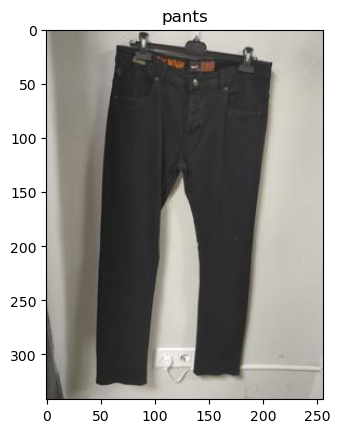

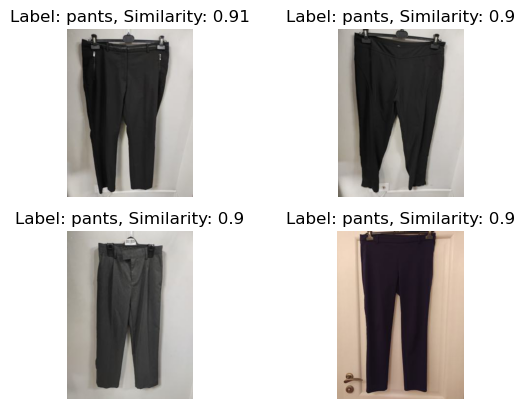

In [94]:
item = img_names.NAME[454]
df = top_n(sim_df, item, n=4)

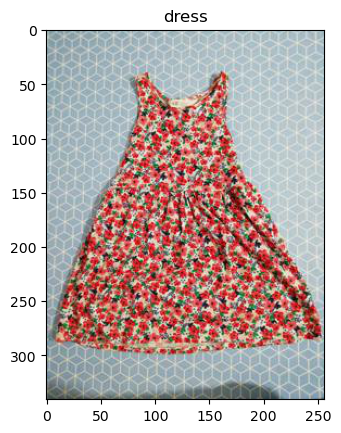

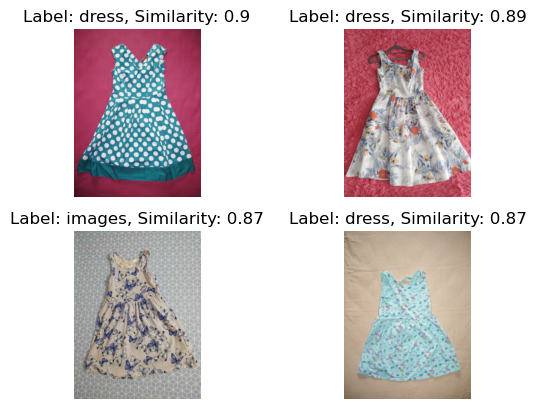

In [714]:
item = img_names.NAME[4504]
df = top_n(sim_df, item, n=4)

CPU times: user 1.32 s, sys: 120 ms, total: 1.44 s
Wall time: 13.5 s


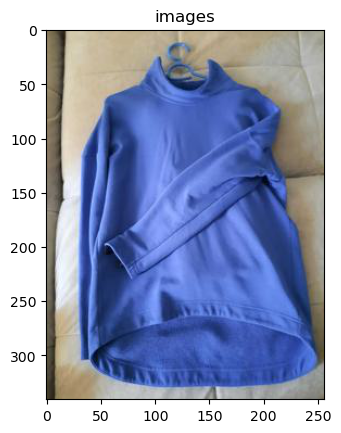

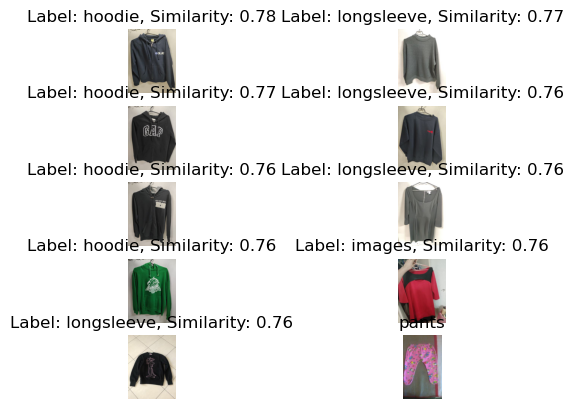

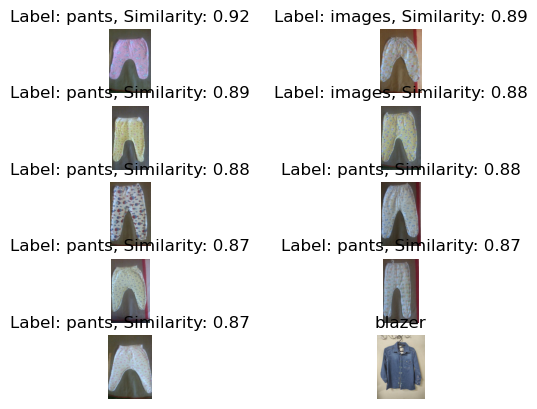

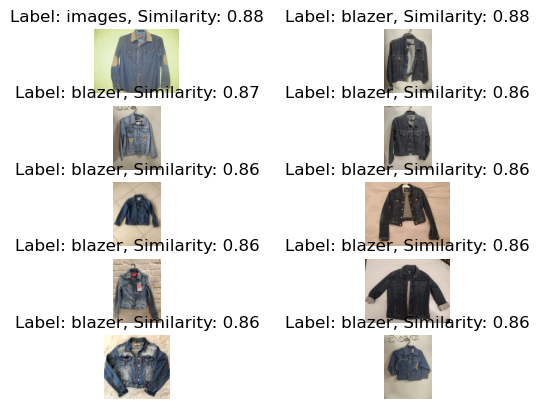

In [624]:
%%time

import random
item = img_names.NAME
index=random.sample(range(0, len(item)), 3)
items=item[index]
df = [top_n(sim_df, item) for item in items]
    